!pip install accelerate -U -q

In [ ]:
!pip install datasets -q

In [ ]:
!pip install transformers -q

In [ ]:
!pip install evaluate -q

In [ ]:
!pip install nltk -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.ticker as ticker
from transformers import get_scheduler
import matplotlib.pyplot as plt

import numpy as np

import random
import math
import time
import string
import re

# datasets from huggingface
import transformers
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

import nltk
from nltk.corpus import stopwords

from tqdm.notebook import tqdm
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import os
from datetime import datetime
from torch.nn.utils.rnn import pad_sequence

from transformers import TrainingArguments, Trainer
import evaluate
import accelerate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
class TransformerClassificationModel(nn.Module):
    #Будем передавать в kwargs еще и num_layers, тогда дополнительный полносвязный слой не понадобится
    def __init__(self, base_transformer_model_huggingface_name=None, base_transformer_model=None, **kwargs):
        assert base_transformer_model is not None or base_transformer_model_huggingface_name is not None
        super().__init__()
        if base_transformer_model_huggingface_name is not None:
            self.backbone = transformers.AutoModelForSequenceClassification.from_pretrained(base_transformer_model_huggingface_name,
                                                                                            **kwargs,
                                                                                            output_attentions=True
                                                                                           )
        else:
            self.backbone = base_transformer_model

    def forward(self, attention_mask=None, labels=None, input_ids=None):
        outputs = self.backbone(attention_mask=attention_mask, labels=labels, input_ids=input_ids)
        return outputs

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for w in model.backbone.parameters():
        w._trainable = False
    for w in model.backbone.classifier.parameters():
        w._trainable = True

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
dataset = load_dataset("csv", data_files="/kaggle/input/math-problems/data_problems_translated.csv")
dataset = dataset.remove_columns('Unnamed: 0')
dataset

DatasetDict({
    train: Dataset({
        features: ['problem_text', 'topic'],
        num_rows: 5273
    })
})

In [ ]:
label_vocab = set()
for w in dataset['train']['topic']:
    label_vocab.add(w)

label2id = {char: i for i, char in enumerate(label_vocab)}
id2label = {i: char for i, char in enumerate(label_vocab)}

label2id

{'geometry': 0,
 'dirichlet': 1,
 'combinatorics': 2,
 'number_theory': 3,
 'polynoms': 4,
 'graphs': 5,
 'invariant': 6}

In [ ]:
dataset = dataset['train'].train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['problem_text', 'topic'],
        num_rows: 4745
    })
    test: Dataset({
        features: ['problem_text', 'topic'],
        num_rows: 528
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    examples['labels'] = torch.tensor([label2id[example] for example in examples['topic']])
    examples['labels'] = examples['labels'].unsqueeze(-1)
    return tokenizer(examples["problem_text"], truncation=True, padding='max_length', max_length=128, return_tensors='pt')

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/528 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions, _ = predictions
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
import copy

def train_transformer(transformer_model, freeze_backbone=True, batch_size=8, epochs=10, lr=2e-5):
    #     model = copy.copy(transformer_model)

    model = TransformerClassificationModel(
        transformer_model,
        None,
        num_labels=id2label.__len__(),
        id2label=id2label,
        label2id=label2id,
#         output_attentions=True
    )

    if freeze_backbone:
        freeze_backbone_function(model)

    training_args = TrainingArguments(
        output_dir="/kaggle/working/",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rubert_tiny_finetuned_with_freezed_backbone = train_transformer('cointegrated/rubert-tiny2', freeze_backbone=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
rubert_tiny_full_finetuned = train_transformer('cointegrated/rubert-tiny2', freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


full_finetuned вариант дообучения сильно переобучился, понятно почему, а с замороженным backbone сильного переобучения и было достигнуто большее качество.

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
mathbert_finetuned_with_freezed_backbone = train_transformer('tbs17/MathBert', freeze_backbone=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mathbert_full_finetuned = train_transformer('tbs17/MathBert', freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Заморозка почти ничго не изменила, модль предобученна на различных математических текстах на английском, вроятно что полученное с помощью этой модели качество превосходит качество с использованием модели, предобученной на более общем корпусе.

MathBert - это специально

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
import seaborn as sns

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids, text: str, label: str, model: TransformerClassificationModel, model_name: str):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    attention_outputs = outputs.attentions[0][0].cpu() # берем выходы attention слоев для первого слоя
    attention_outputs = attention_outputs[attention_head_ids]

    input_labels = tokenizer.batch_decode(inputs['input_ids'].tolist()[0]) # разбиваем текст на токены
    fig, axs = plt.subplots(ncols=len(attention_head_ids), figsize=(40, 15))

    fig.suptitle('Self-Attention Weights for model: \'{0}\'; text: \'{1}\''.format(model_name, text), fontsize=30)
    for i in range(len(attention_head_ids)):
        axs[i].set_title("Head {0}".format(attention_head_ids[i]))

        sns.heatmap(attention_outputs[i],
                ax=axs[i],
                cmap='viridis',
                annot=True,
                fmt=".2f",
                square=True,
                cbar=True,
                xticklabels=input_labels,
                yticklabels=input_labels
               )

        axs[i].set_xlabel("Key")
        axs[i].set_ylabel("Query")
        axs[i].legend()

    plt.show()
    print('Predicted label: {0}; Real label: {1}'.format(id2label[outputs.logits.argmax(1)[0].item()], label))

### Задание 7 (1 балл)

Проведите инференс для всех моделей до дообучения на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Постарался найти довольно короткие и интересные предложения.

In [ ]:
test_data = dataset['test'][np.random.permutation(528)[:2]]
test_data

{'problem_text': ['Is there a broken picture that crosses all the ribs once?',
  'It is known that a5 is a3 + a = 2. Prove that a6 > 3.'],
 'topic': ['graphs', 'polynoms']}

In [ ]:
texts = test_data['problem_text']
labels = test_data['topic']
rubert_attention_head_ids = [0, 6, 7] # взяты наиболее интересные головы
mathbert_attention_head_ids = [7, 8, 10]

In [ ]:
rubert_tiny = TransformerClassificationModel(
    'cointegrated/rubert-tiny2',
    None,
    num_labels=id2label.__len__(),
    id2label=id2label,
    label2id=label2id,
).to(device)

mathbert = TransformerClassificationModel(
    'tbs17/MathBert',
    None,
    num_labels=id2label.__len__(),
    id2label=id2label,
    label2id=label2id,
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Извиняюсь за маленькие графики карт внимания. Рекомендуется использовать монитор побольше и ориентироваться по цветам, а не по значениям.

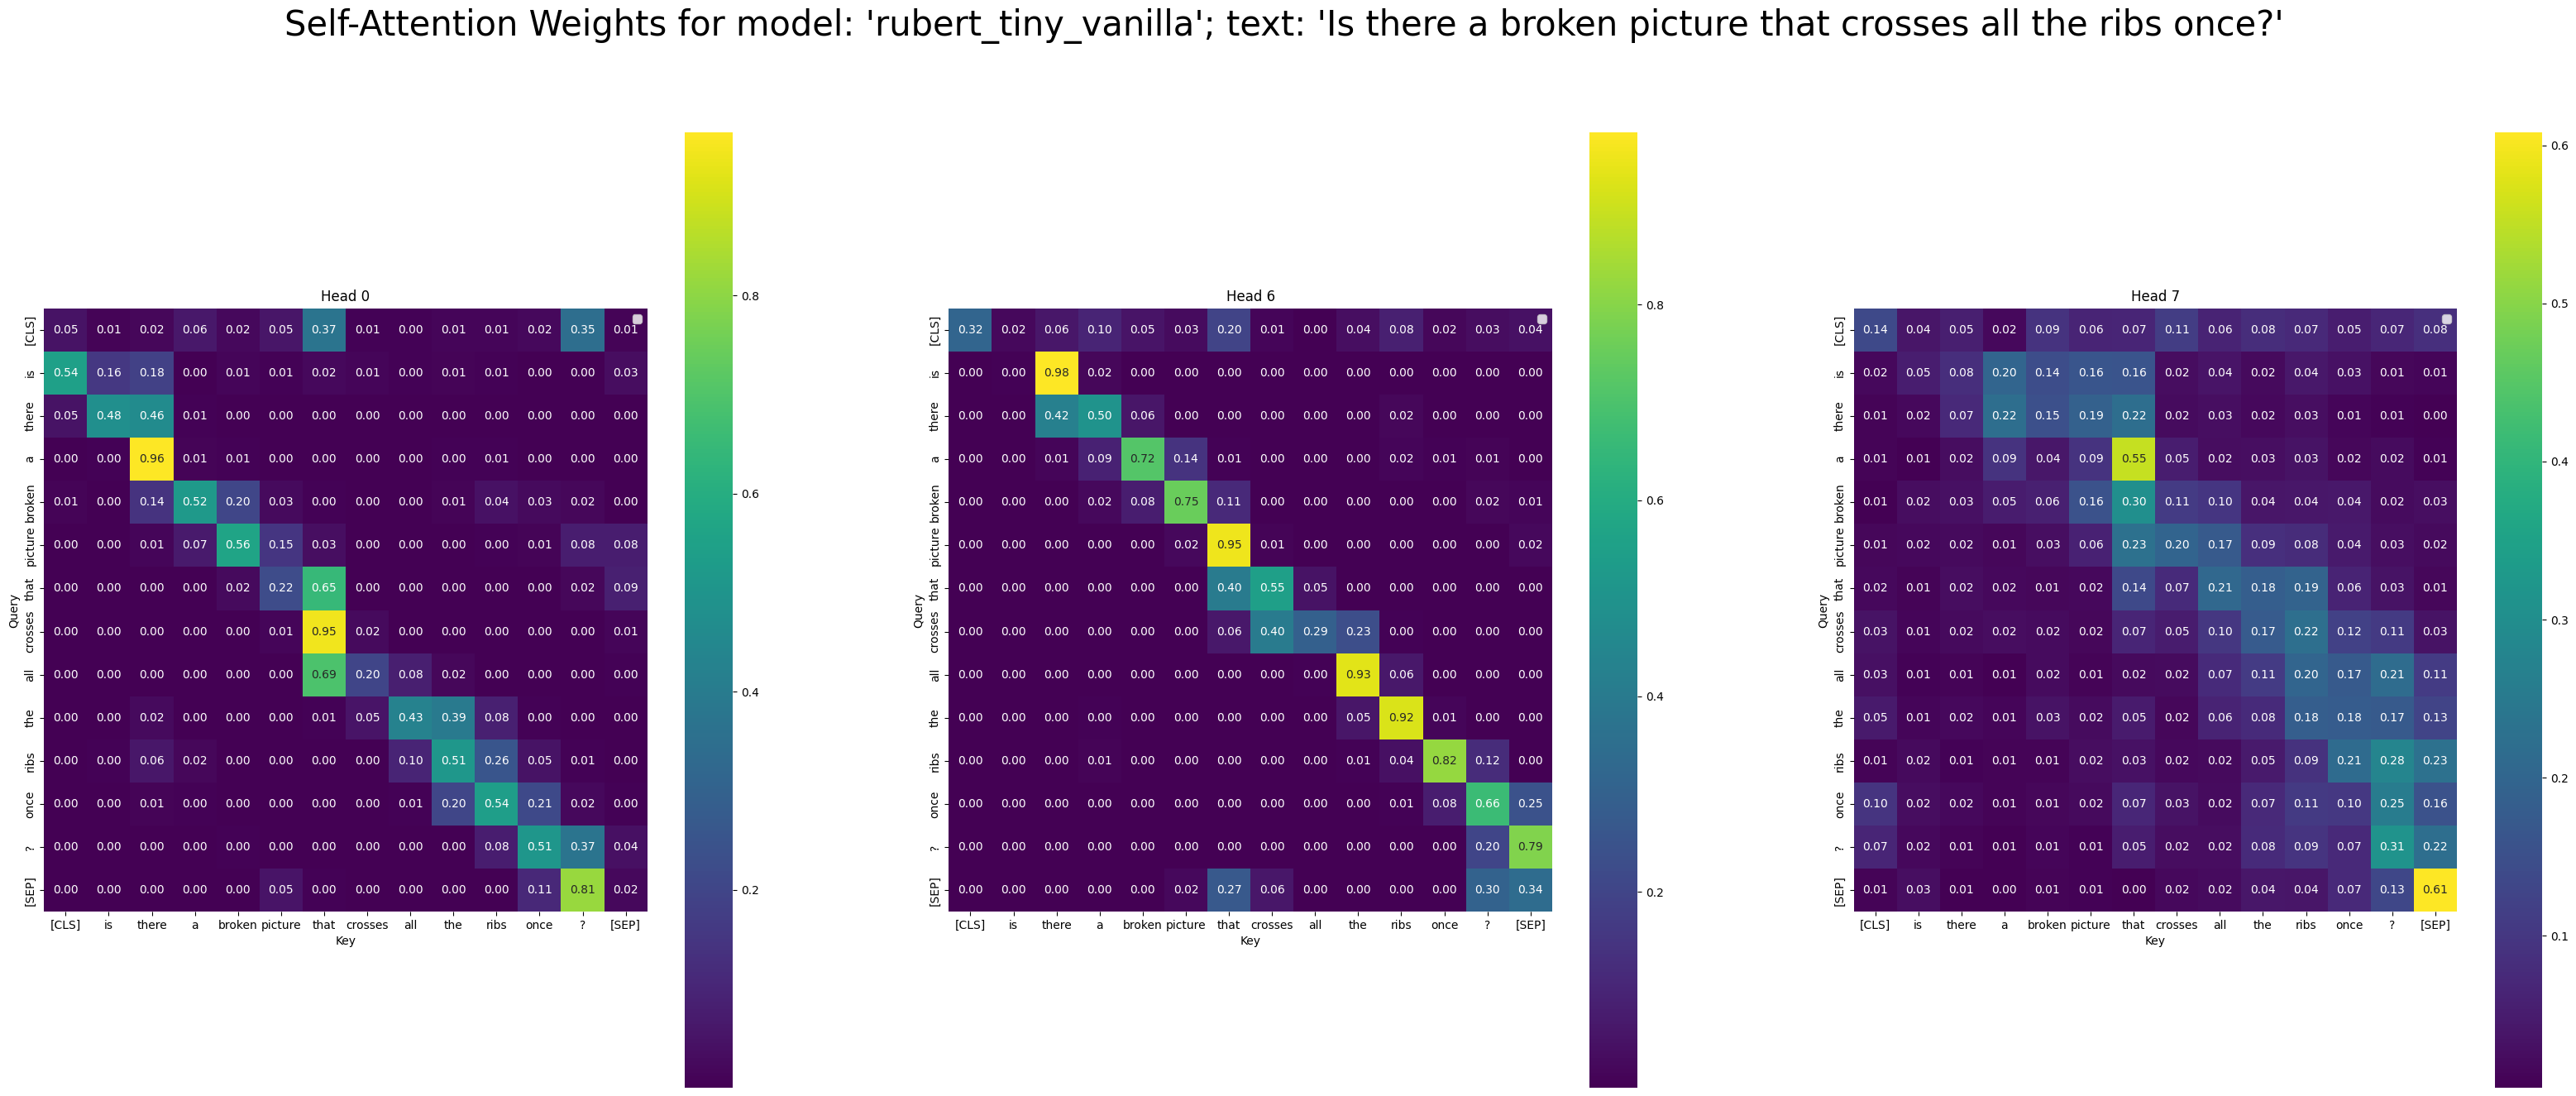

Predicted label: invariant; Real label: graphs


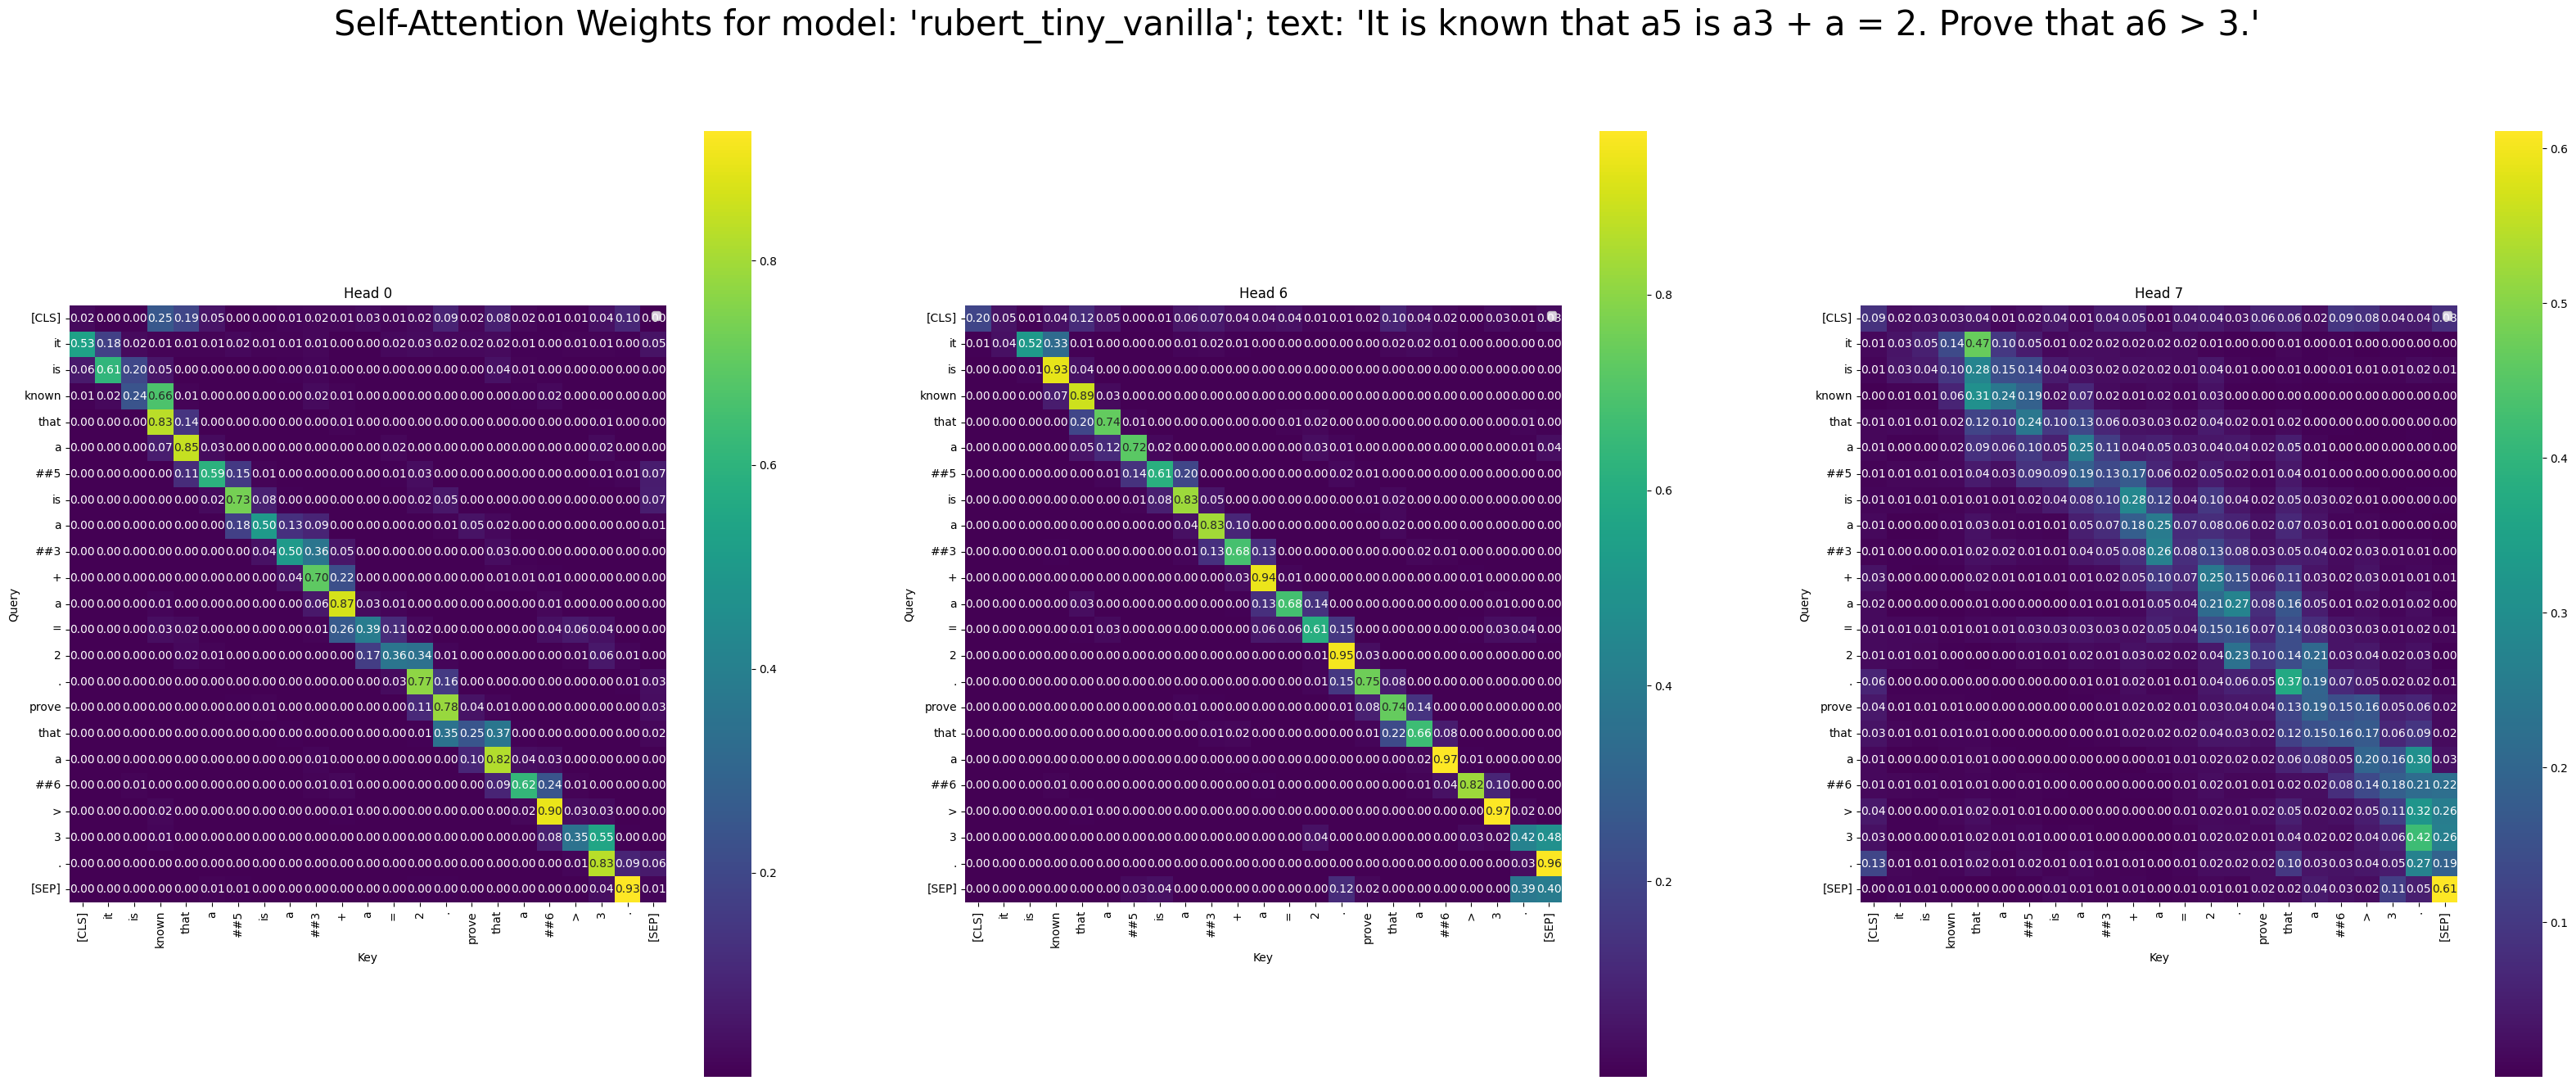

Predicted label: combinatorics; Real label: polynoms


In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=rubert_attention_head_ids,
        model=rubert_tiny,
        model_name='rubert_tiny_vanilla'
    )

Интерпретация


1. 0-голова подтягивает информацию из недалекого прошлого. То есть подтягивается информация из 1-2 ближайших левых слов, опираясь на их важность для query-слова.
2. 6-голова подтягивает информацию из недалекого будущего.
3. 7-голова подтягивает информацию из более далекого будущего. То есть окно внимания растягивается вправо, в итоге захватывая 4-5 слов.

Просмотрев карты внимания, нет голов, которые хорошо распознают математические концепции, обращая внимание на важные для задач слова. Все головы так или иначе обращают внимание на смысловую или синтаксическую связь слов, модель не предназначена для подобного вида задач,корпус для этой модели состоит из разнотипных текстов

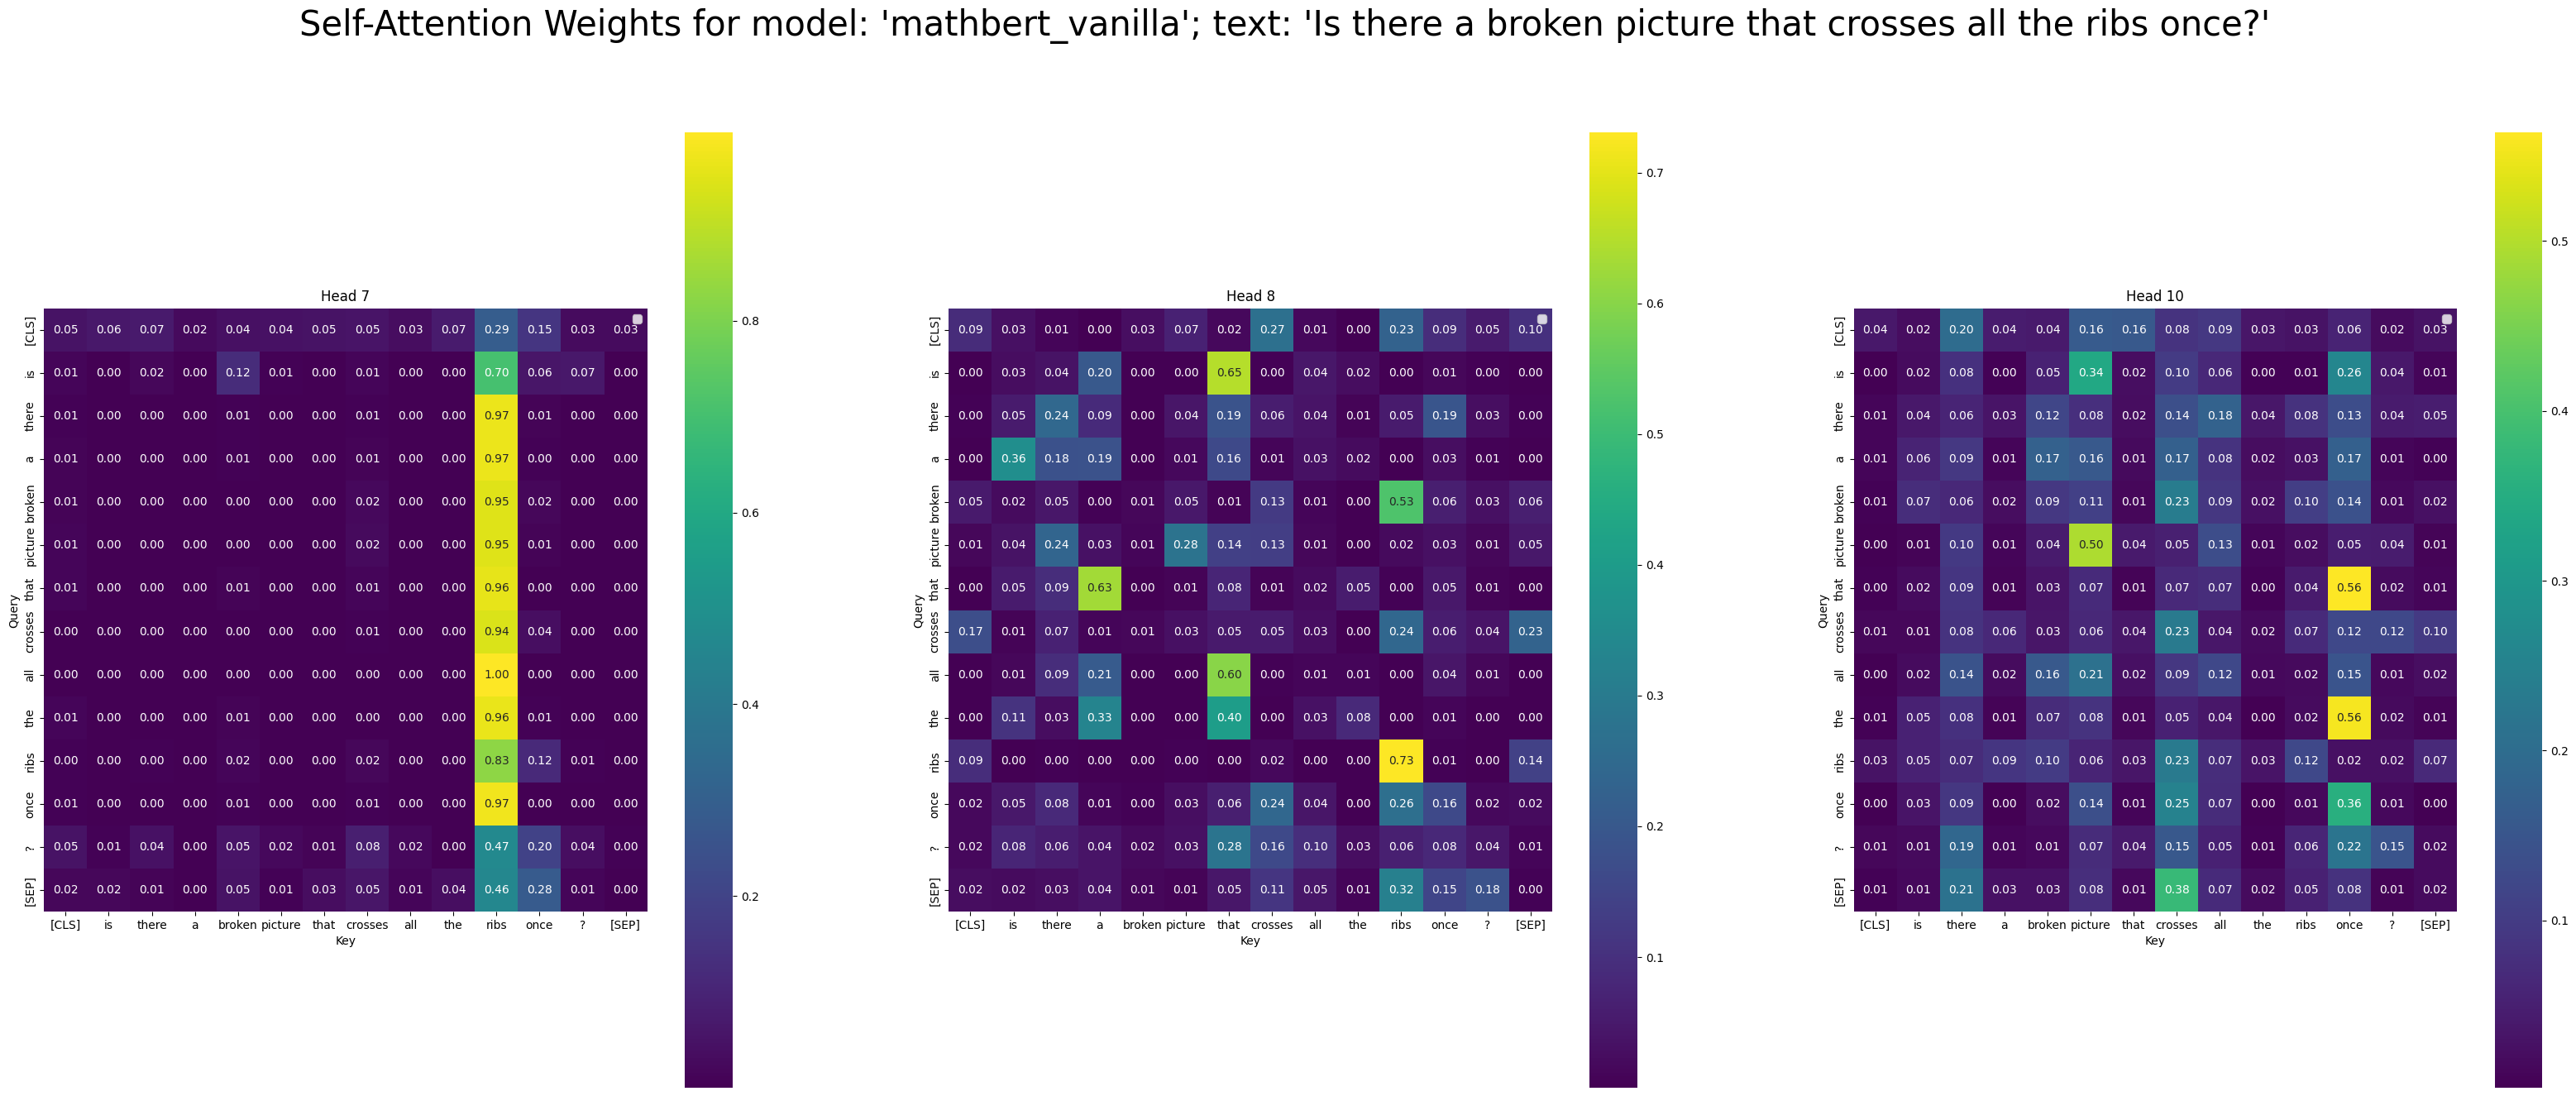

Predicted label: geometry; Real label: graphs


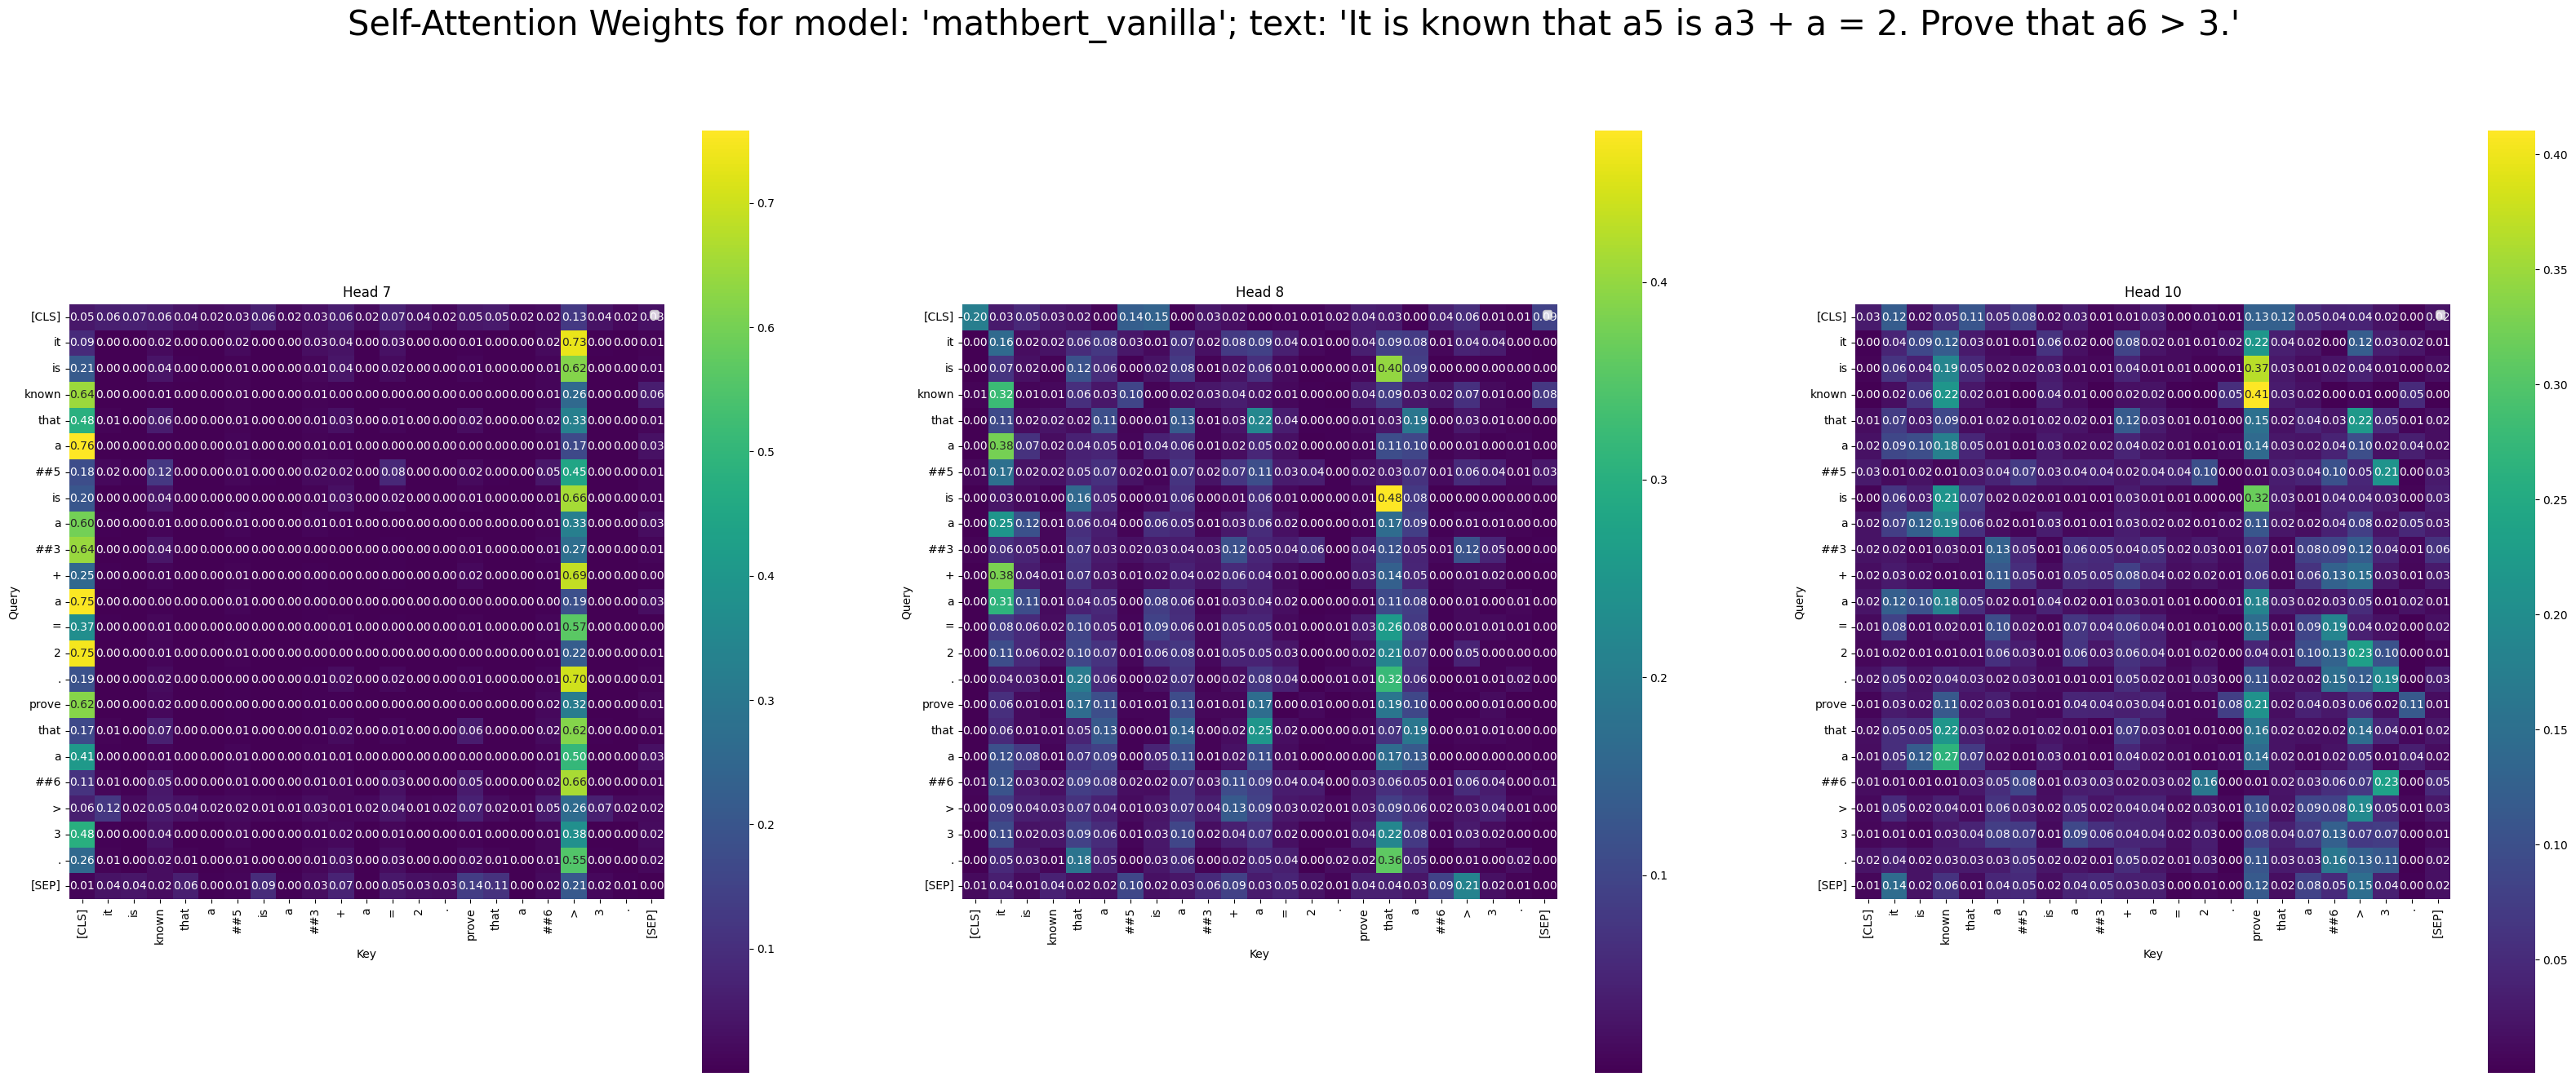

Predicted label: geometry; Real label: polynoms


In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=mathbert_attention_head_ids,
        model=mathbert,
        model_name='mathbert_vanilla'
    )

1. 7-голова обращает внимание на главное математическое слово текста.
2. 8-голова обращает внимание на все слова связанные по смыслу.
3. 10-голова обращает внимание на самые важные математические слова текста.

 MathBert намного лучше подходит для адачи, обращая внимание на важные математические слова, исходя из которых можно отнести текст к конкретной математической проблеме.

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

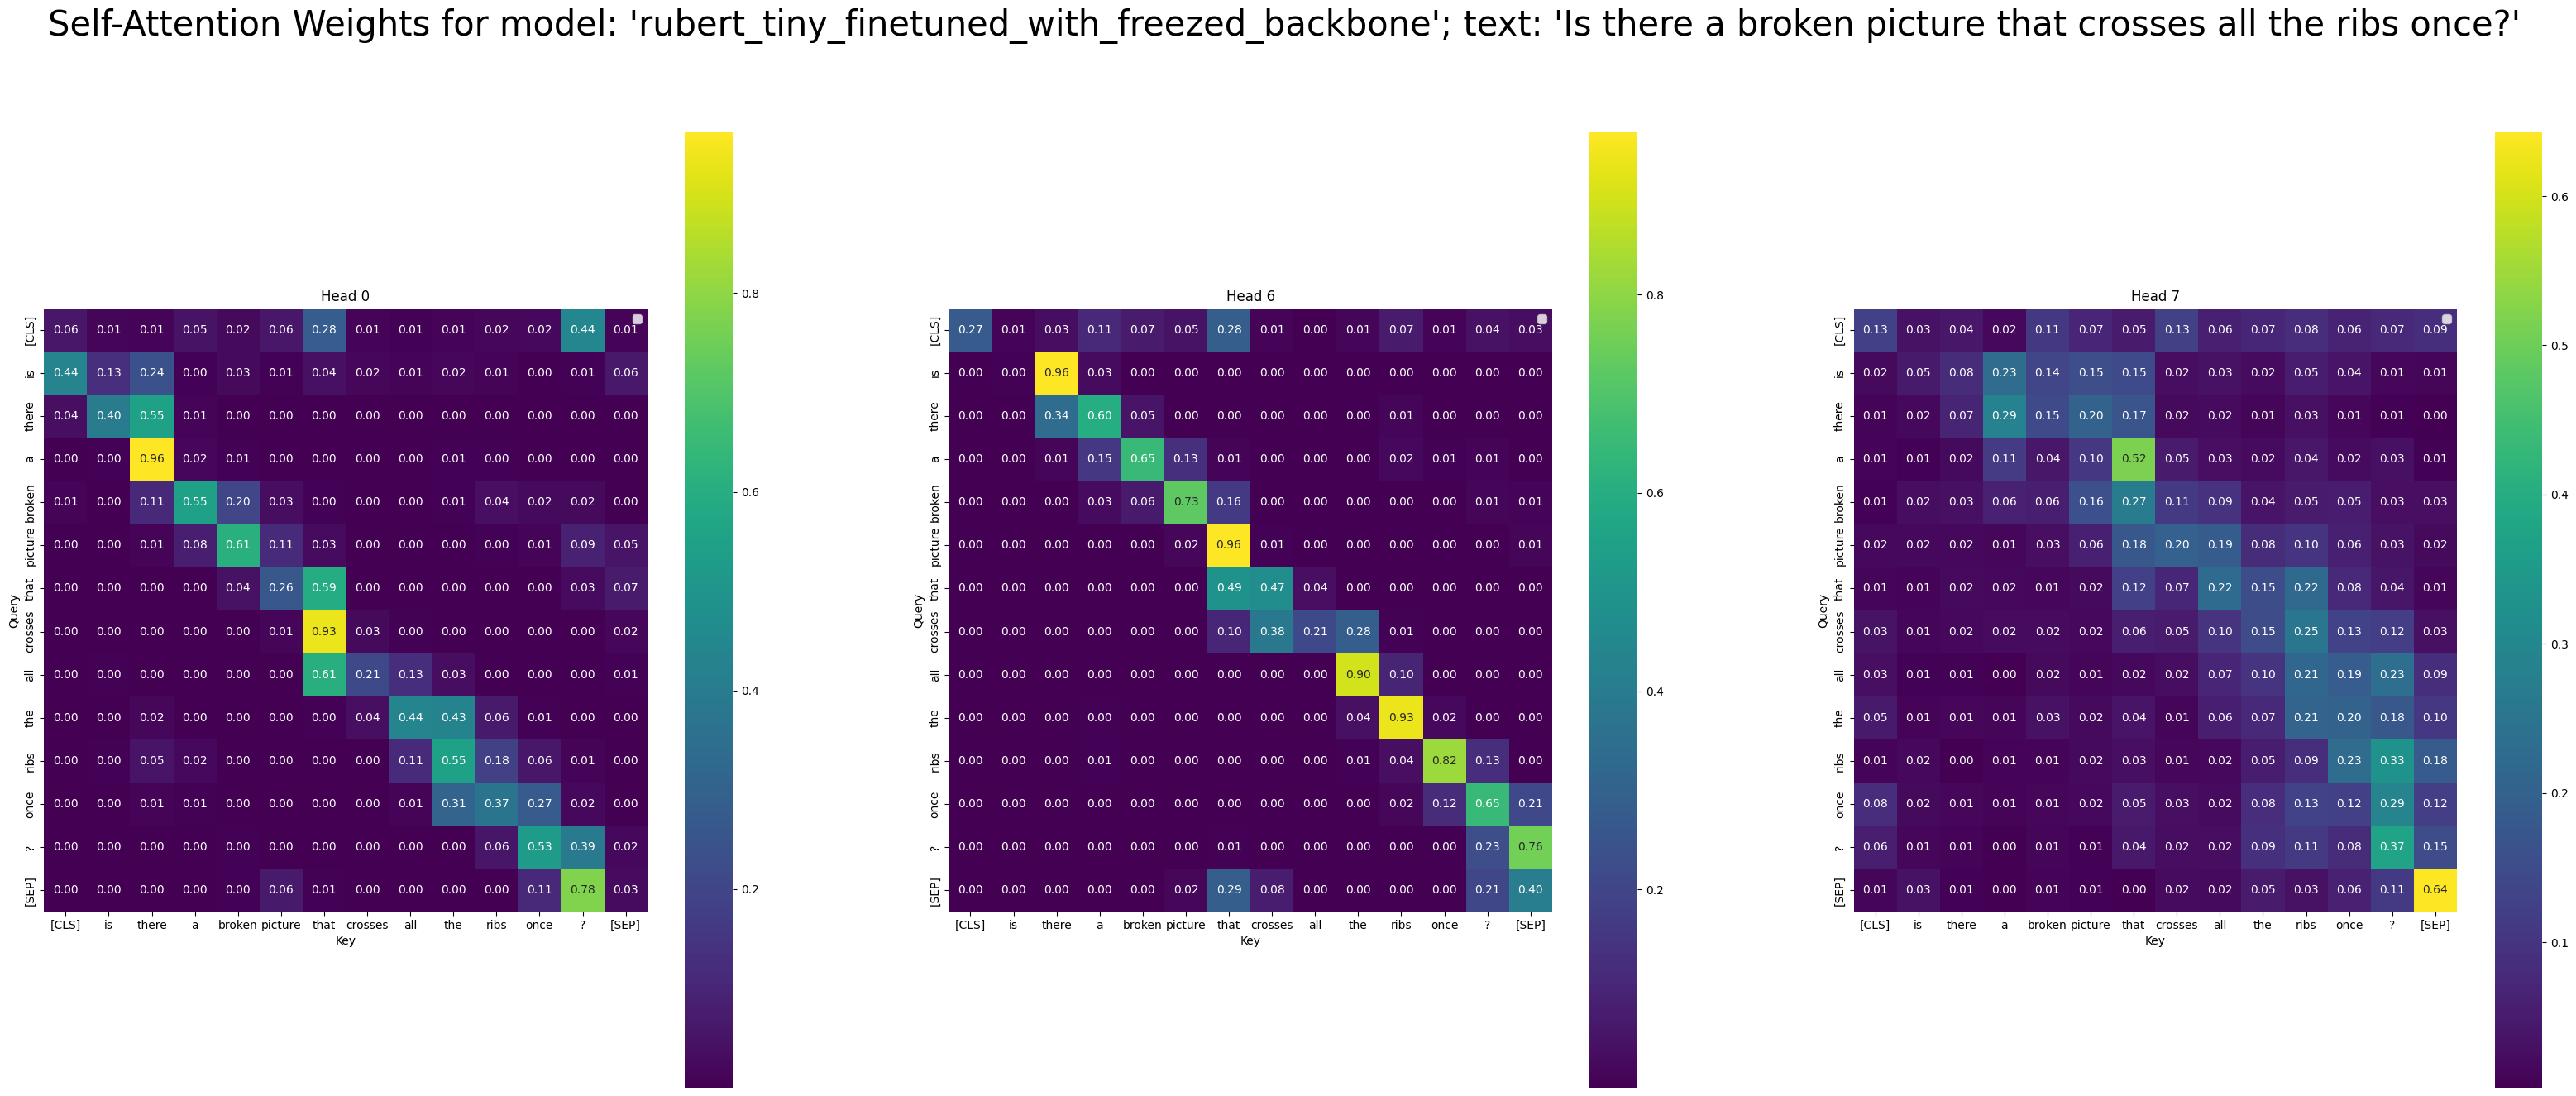

Predicted label: number_theory; Real label: graphs


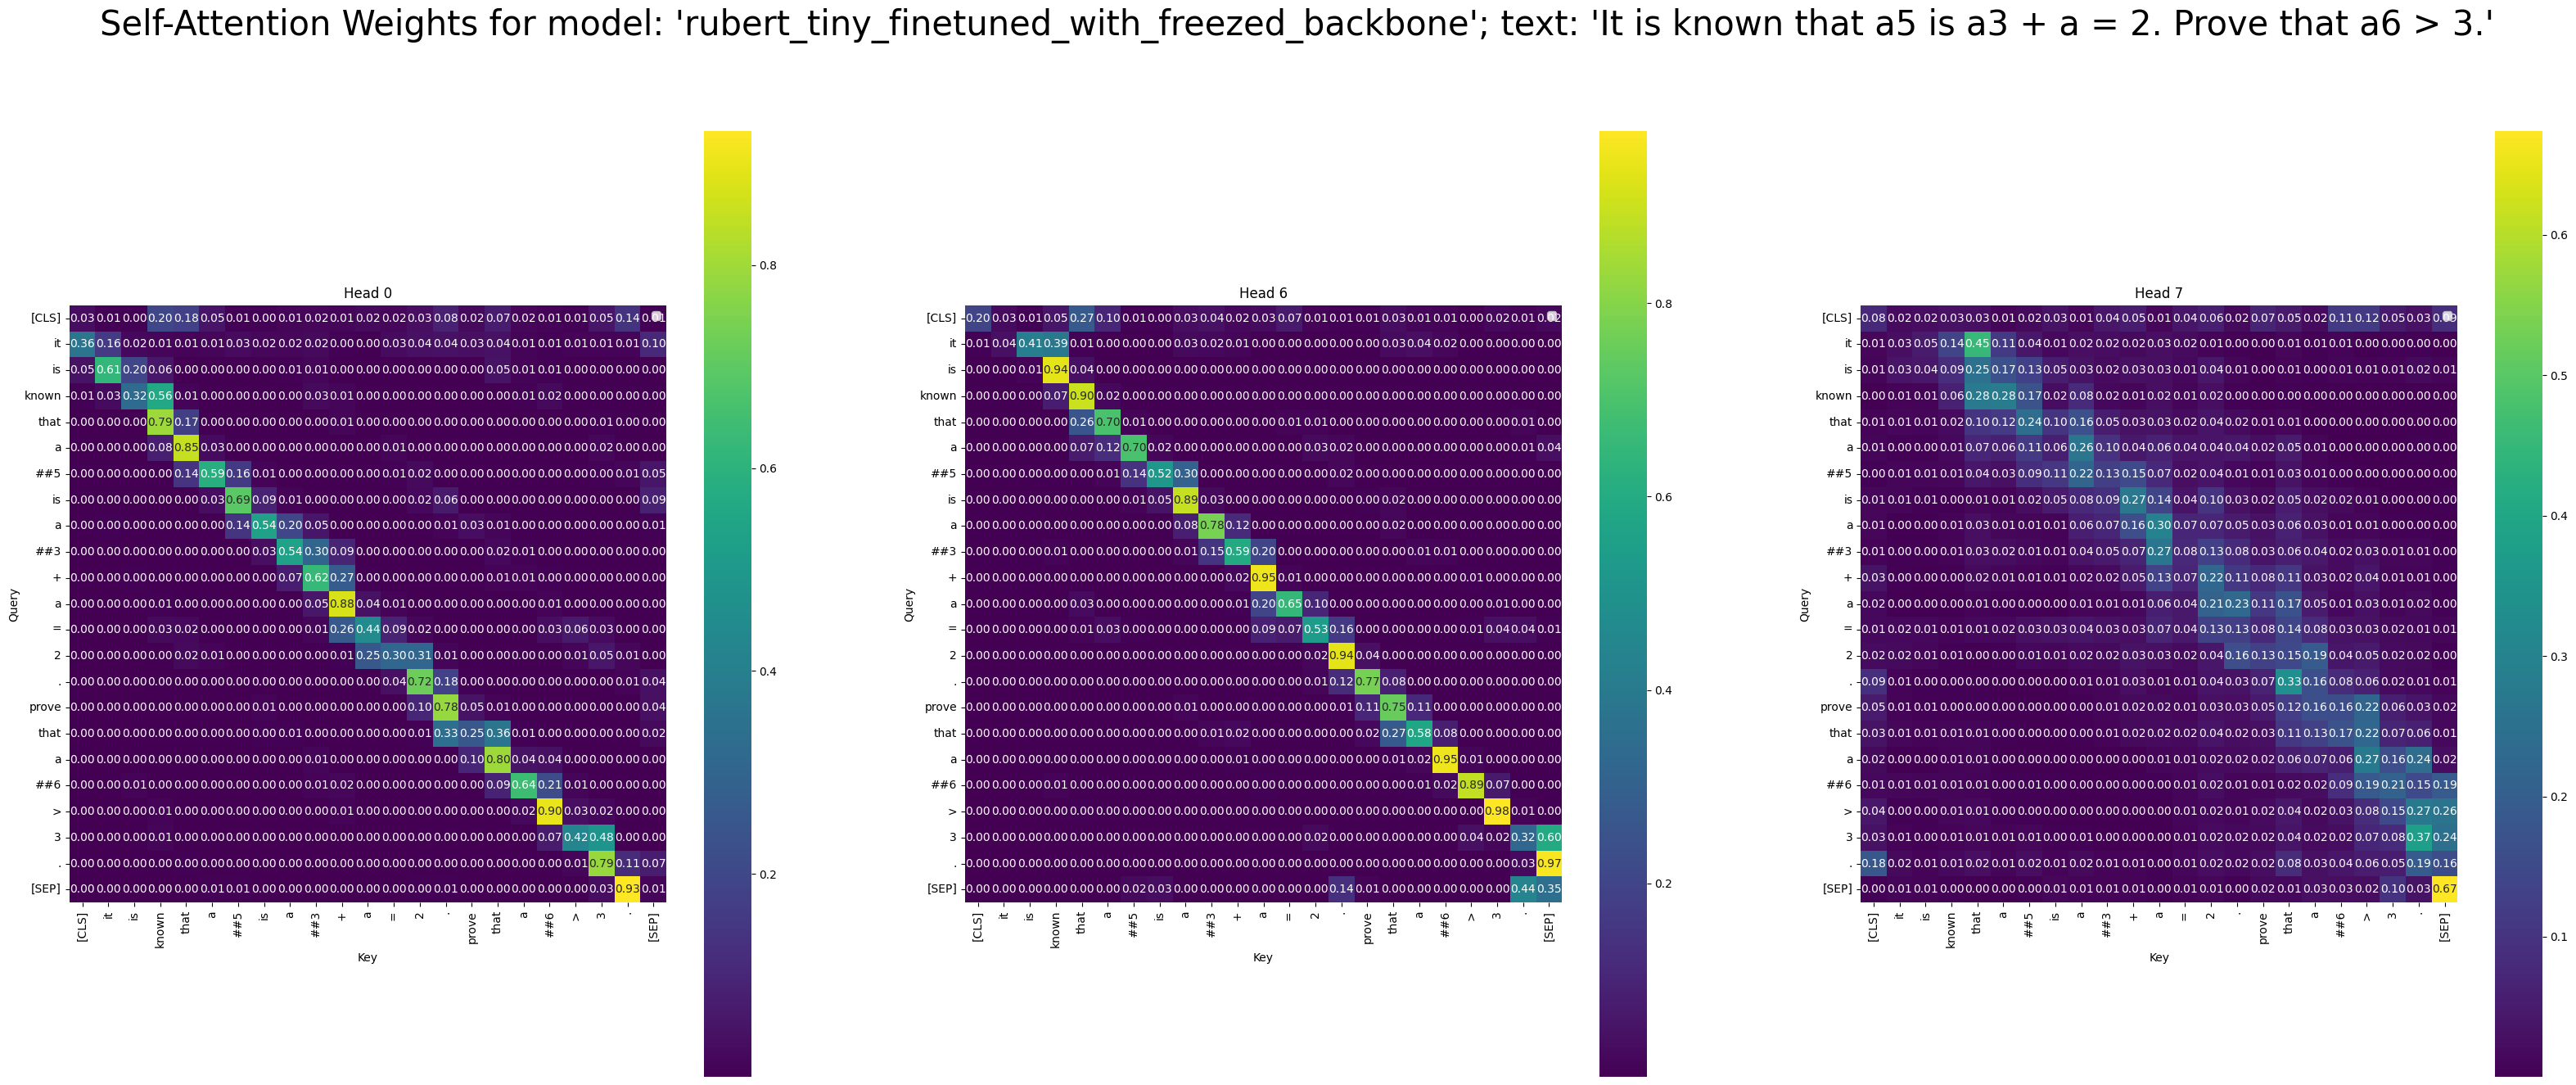

Predicted label: number_theory; Real label: polynoms


In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=rubert_attention_head_ids,
        model=rubert_tiny_finetuned_with_freezed_backbone,
        model_name='rubert_tiny_finetuned_with_freezed_backbone'
    )

изменений нет, так как backbone был заморожен, соответственно ничего измениться и не могло.

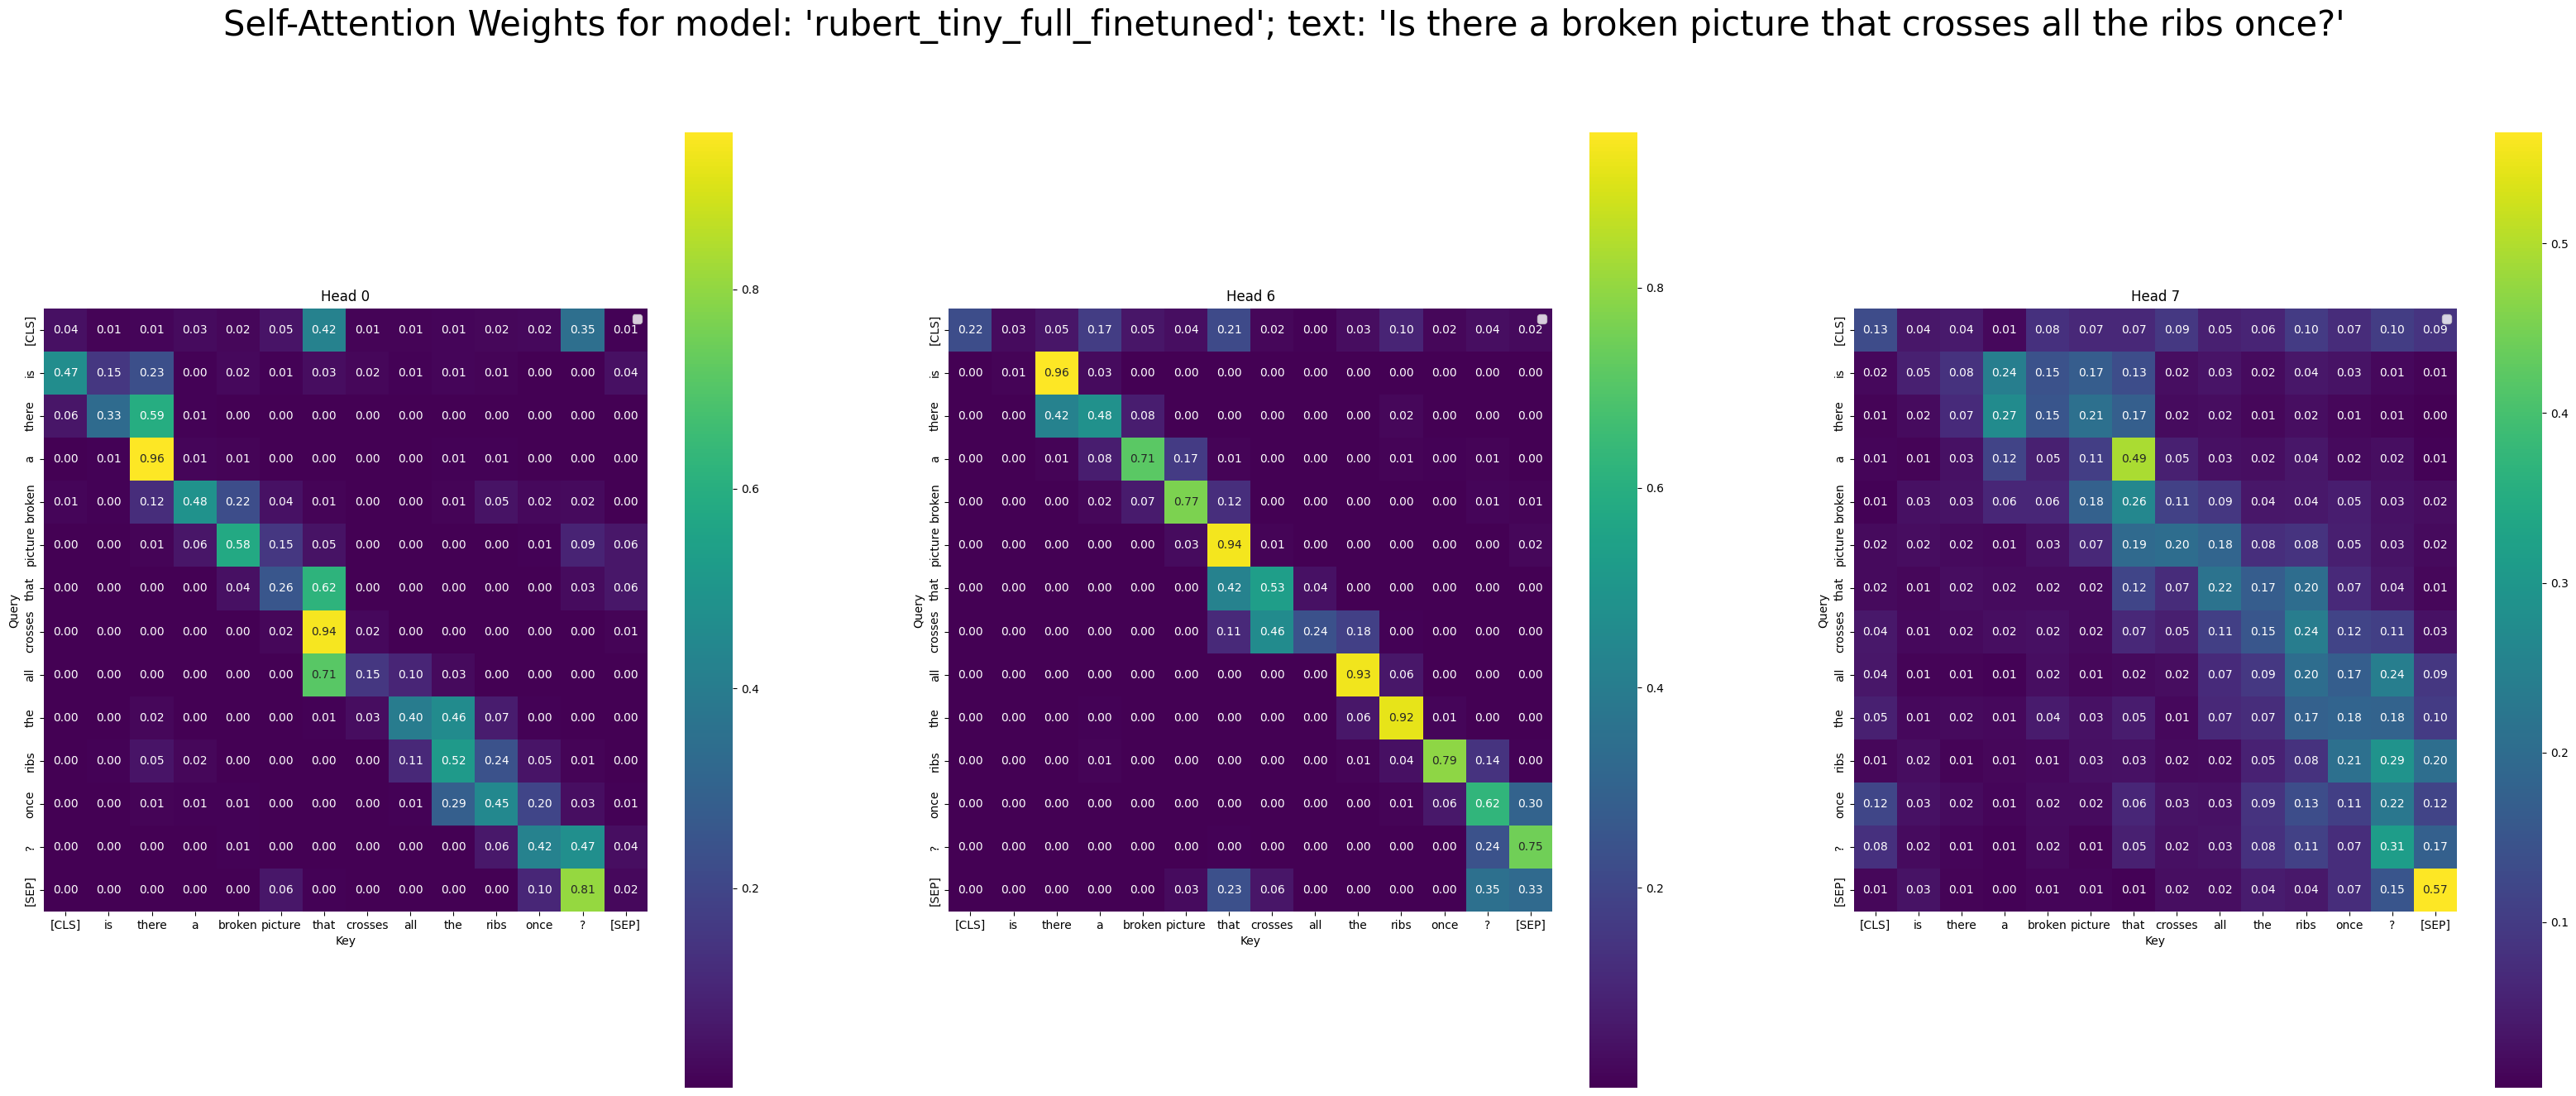

Predicted label: number_theory; Real label: graphs


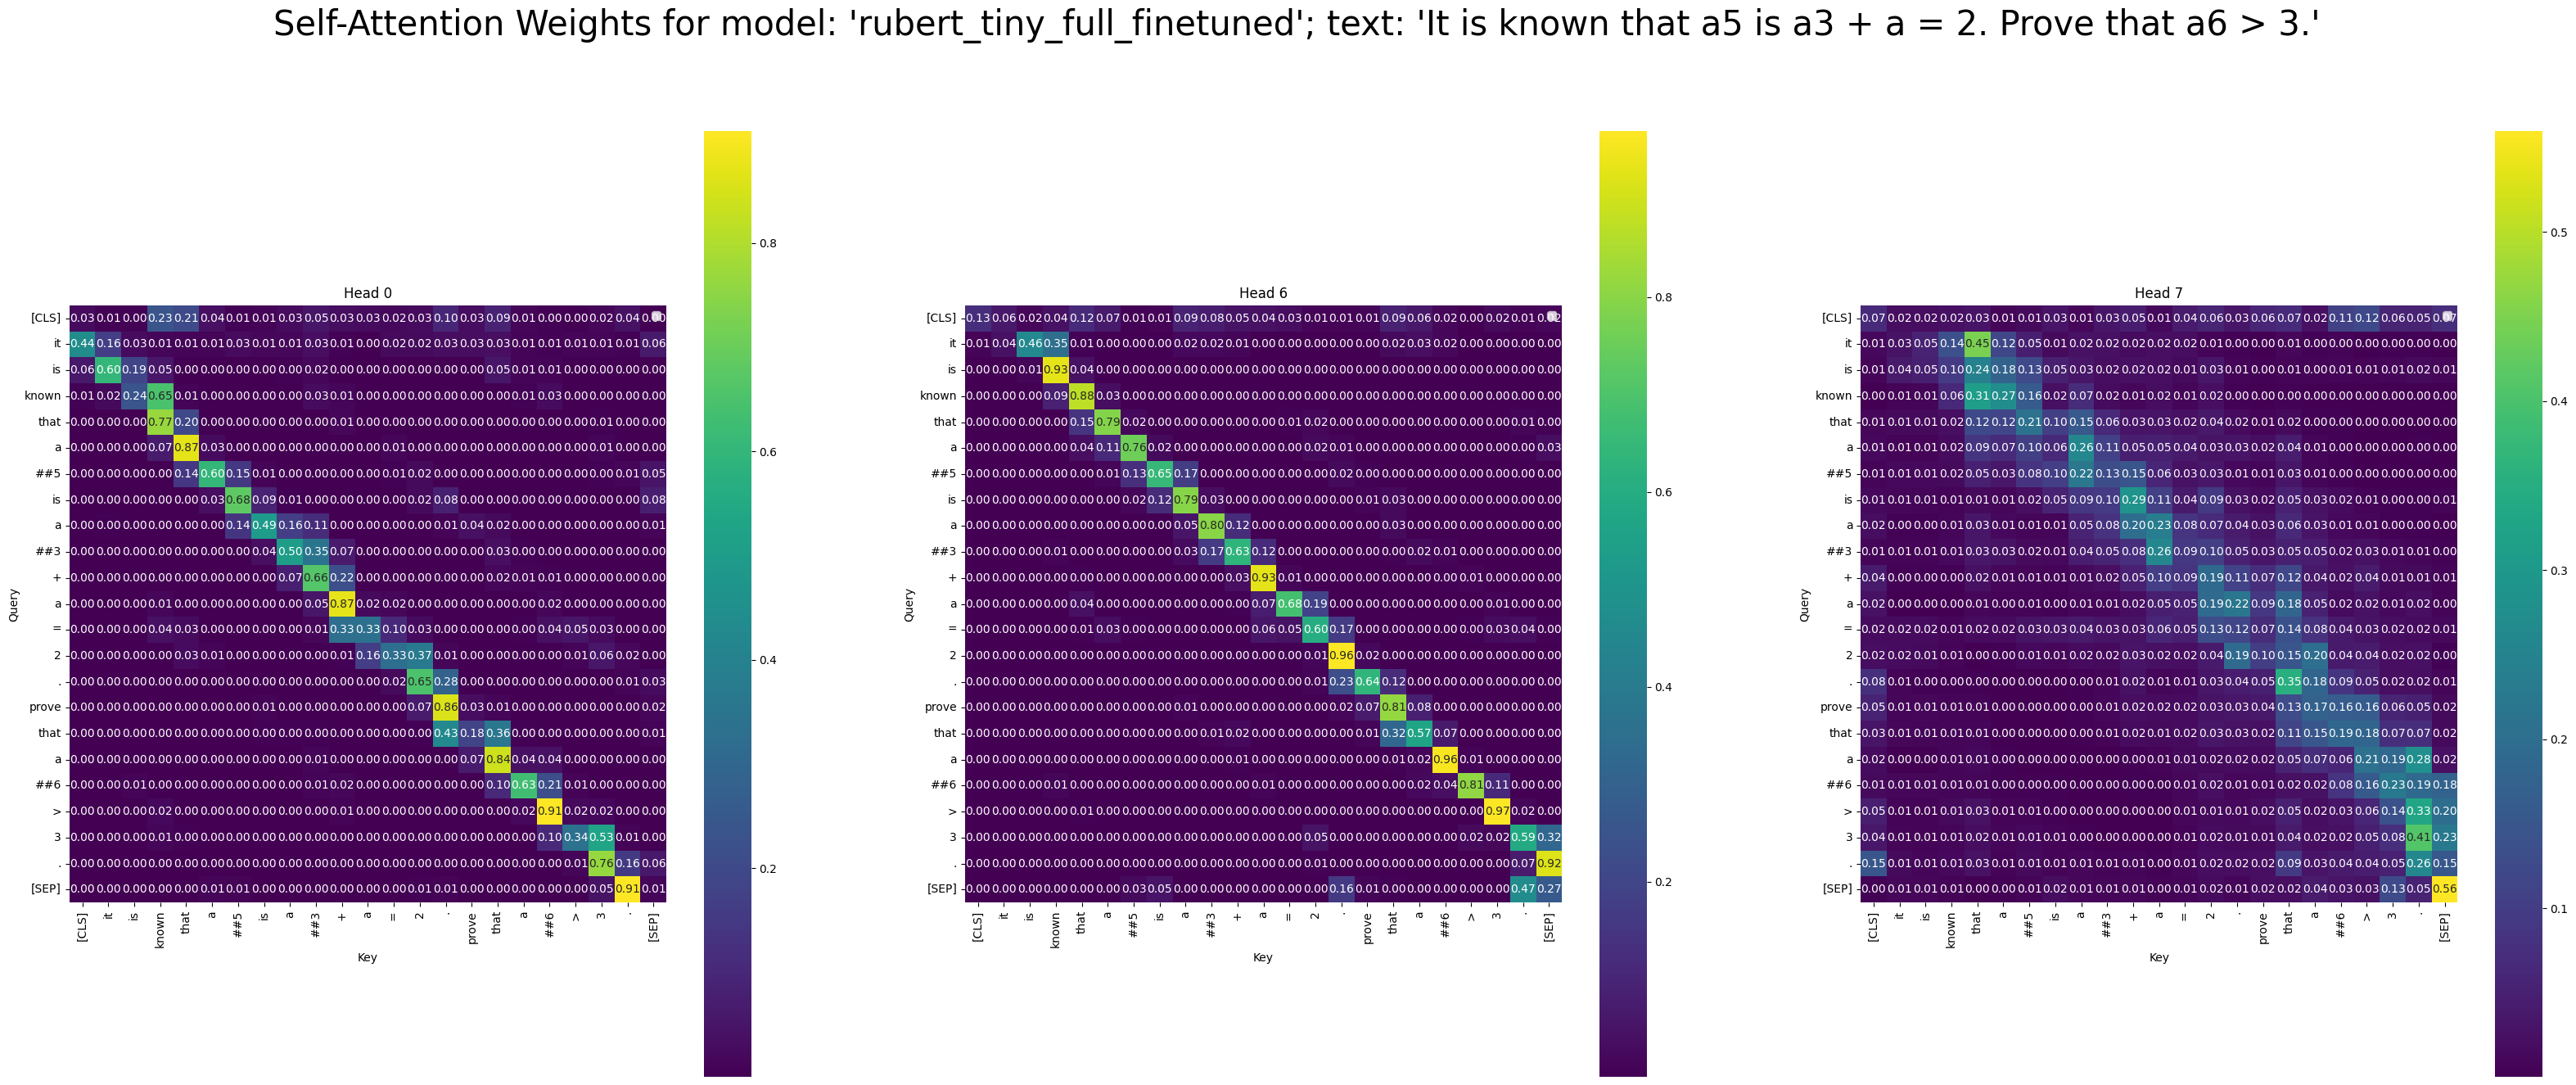

Predicted label: number_theory; Real label: polynoms


In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=rubert_attention_head_ids,
        model=rubert_tiny_full_finetuned,
        model_name='rubert_tiny_full_finetuned'
    )

Изменения карт внимания минимальны, возможно из-за небольшого набора текстов для дообучения.

In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=mathbert_attention_head_ids,
        model=mathbert_finetuned_with_freezed_backbone,
        model_name='mathbert_finetuned_with_freezed_backbone'
    )

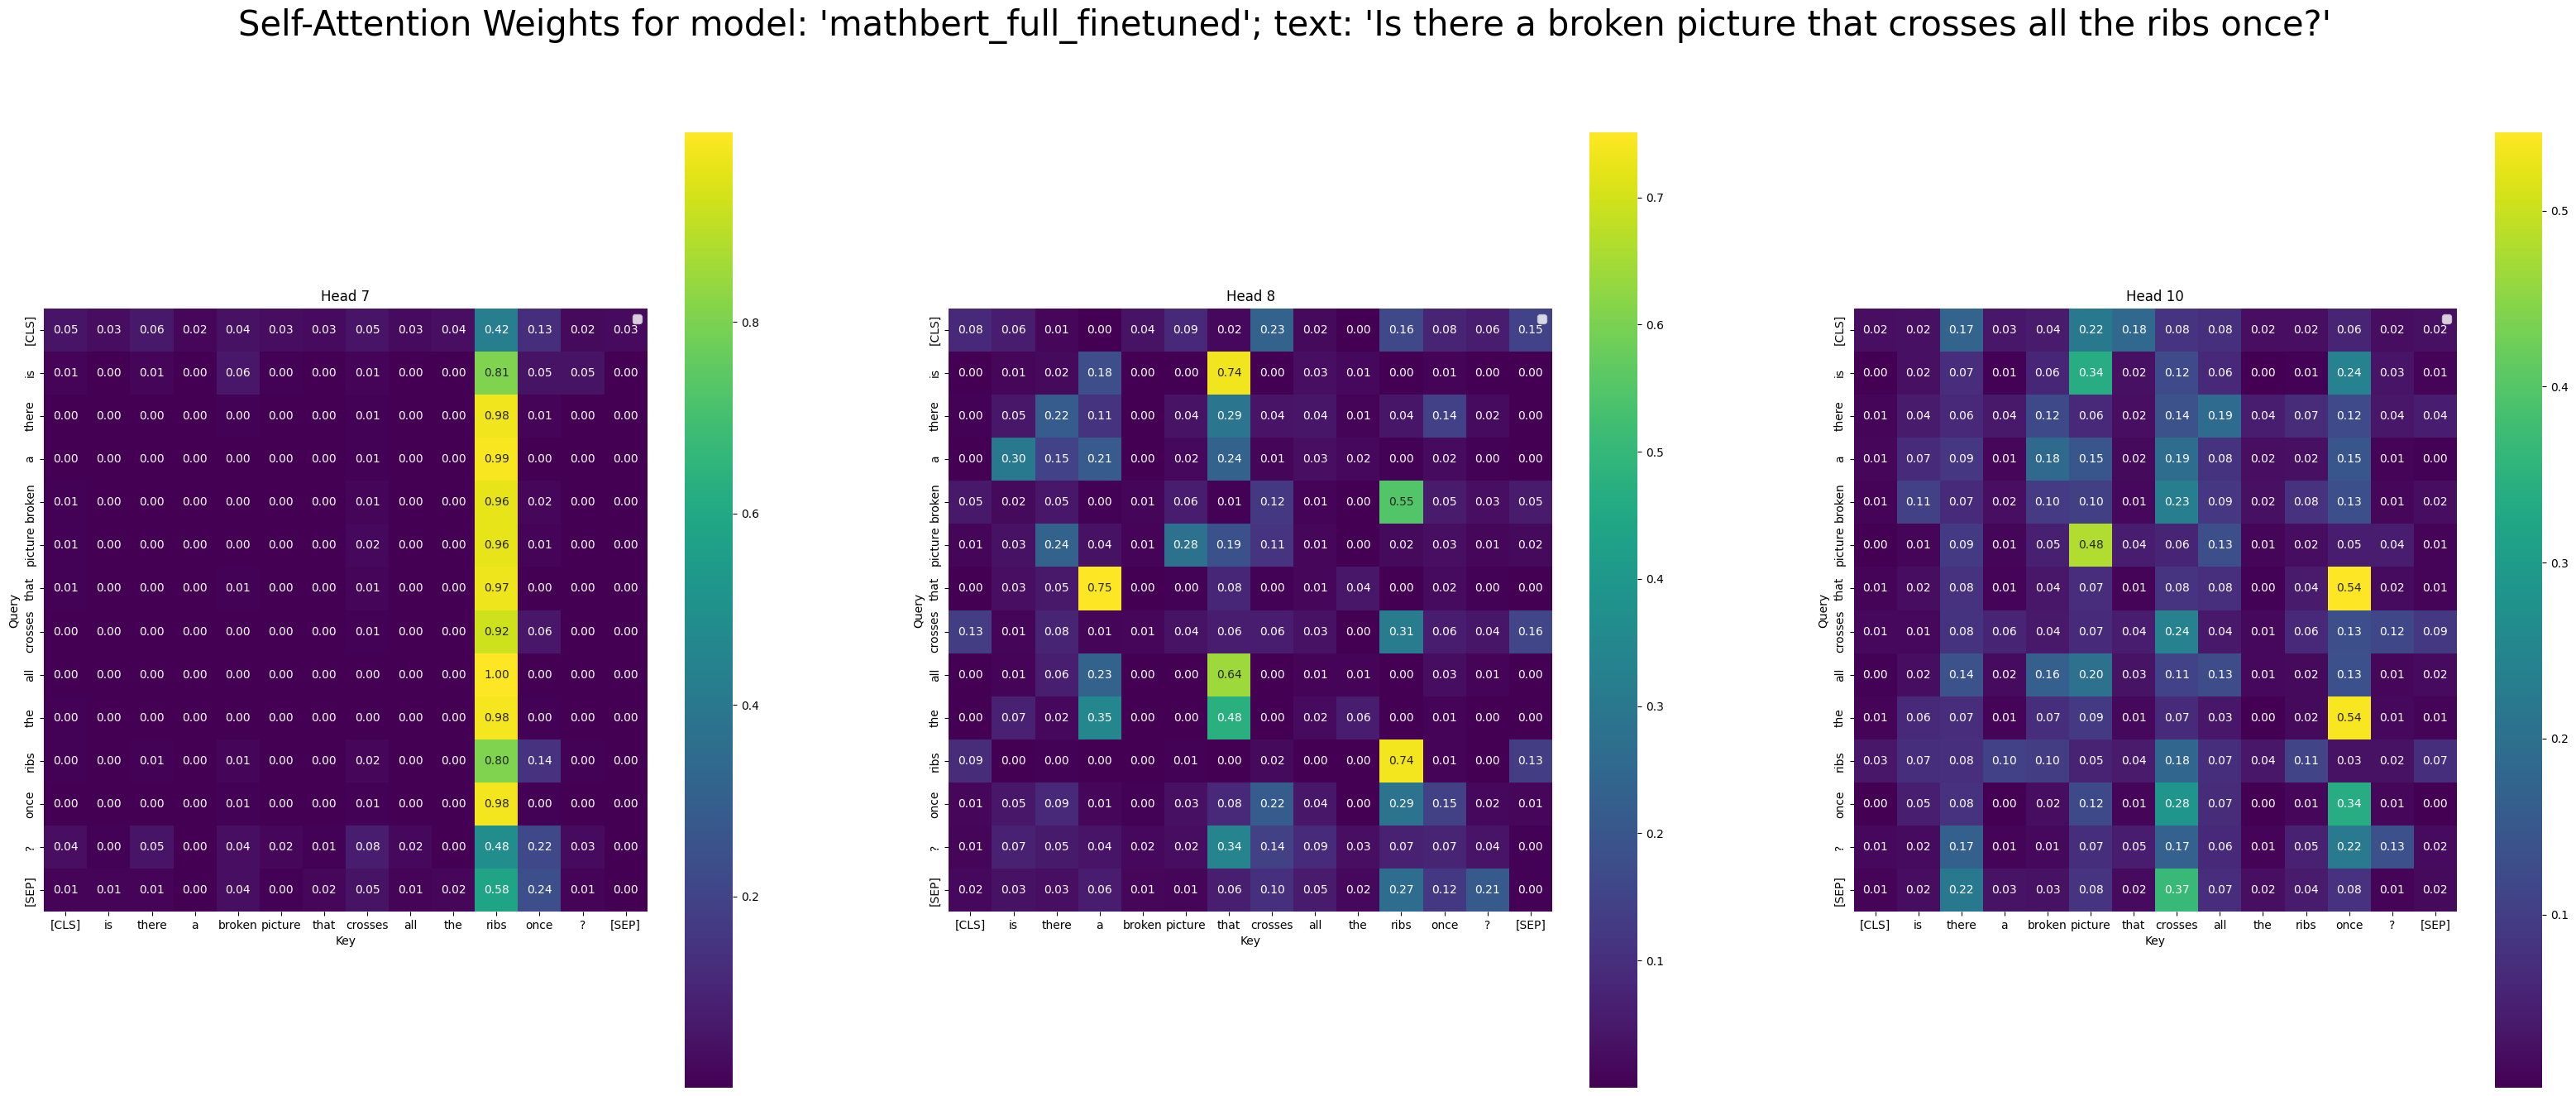

Predicted label: combinatorics; Real label: graphs


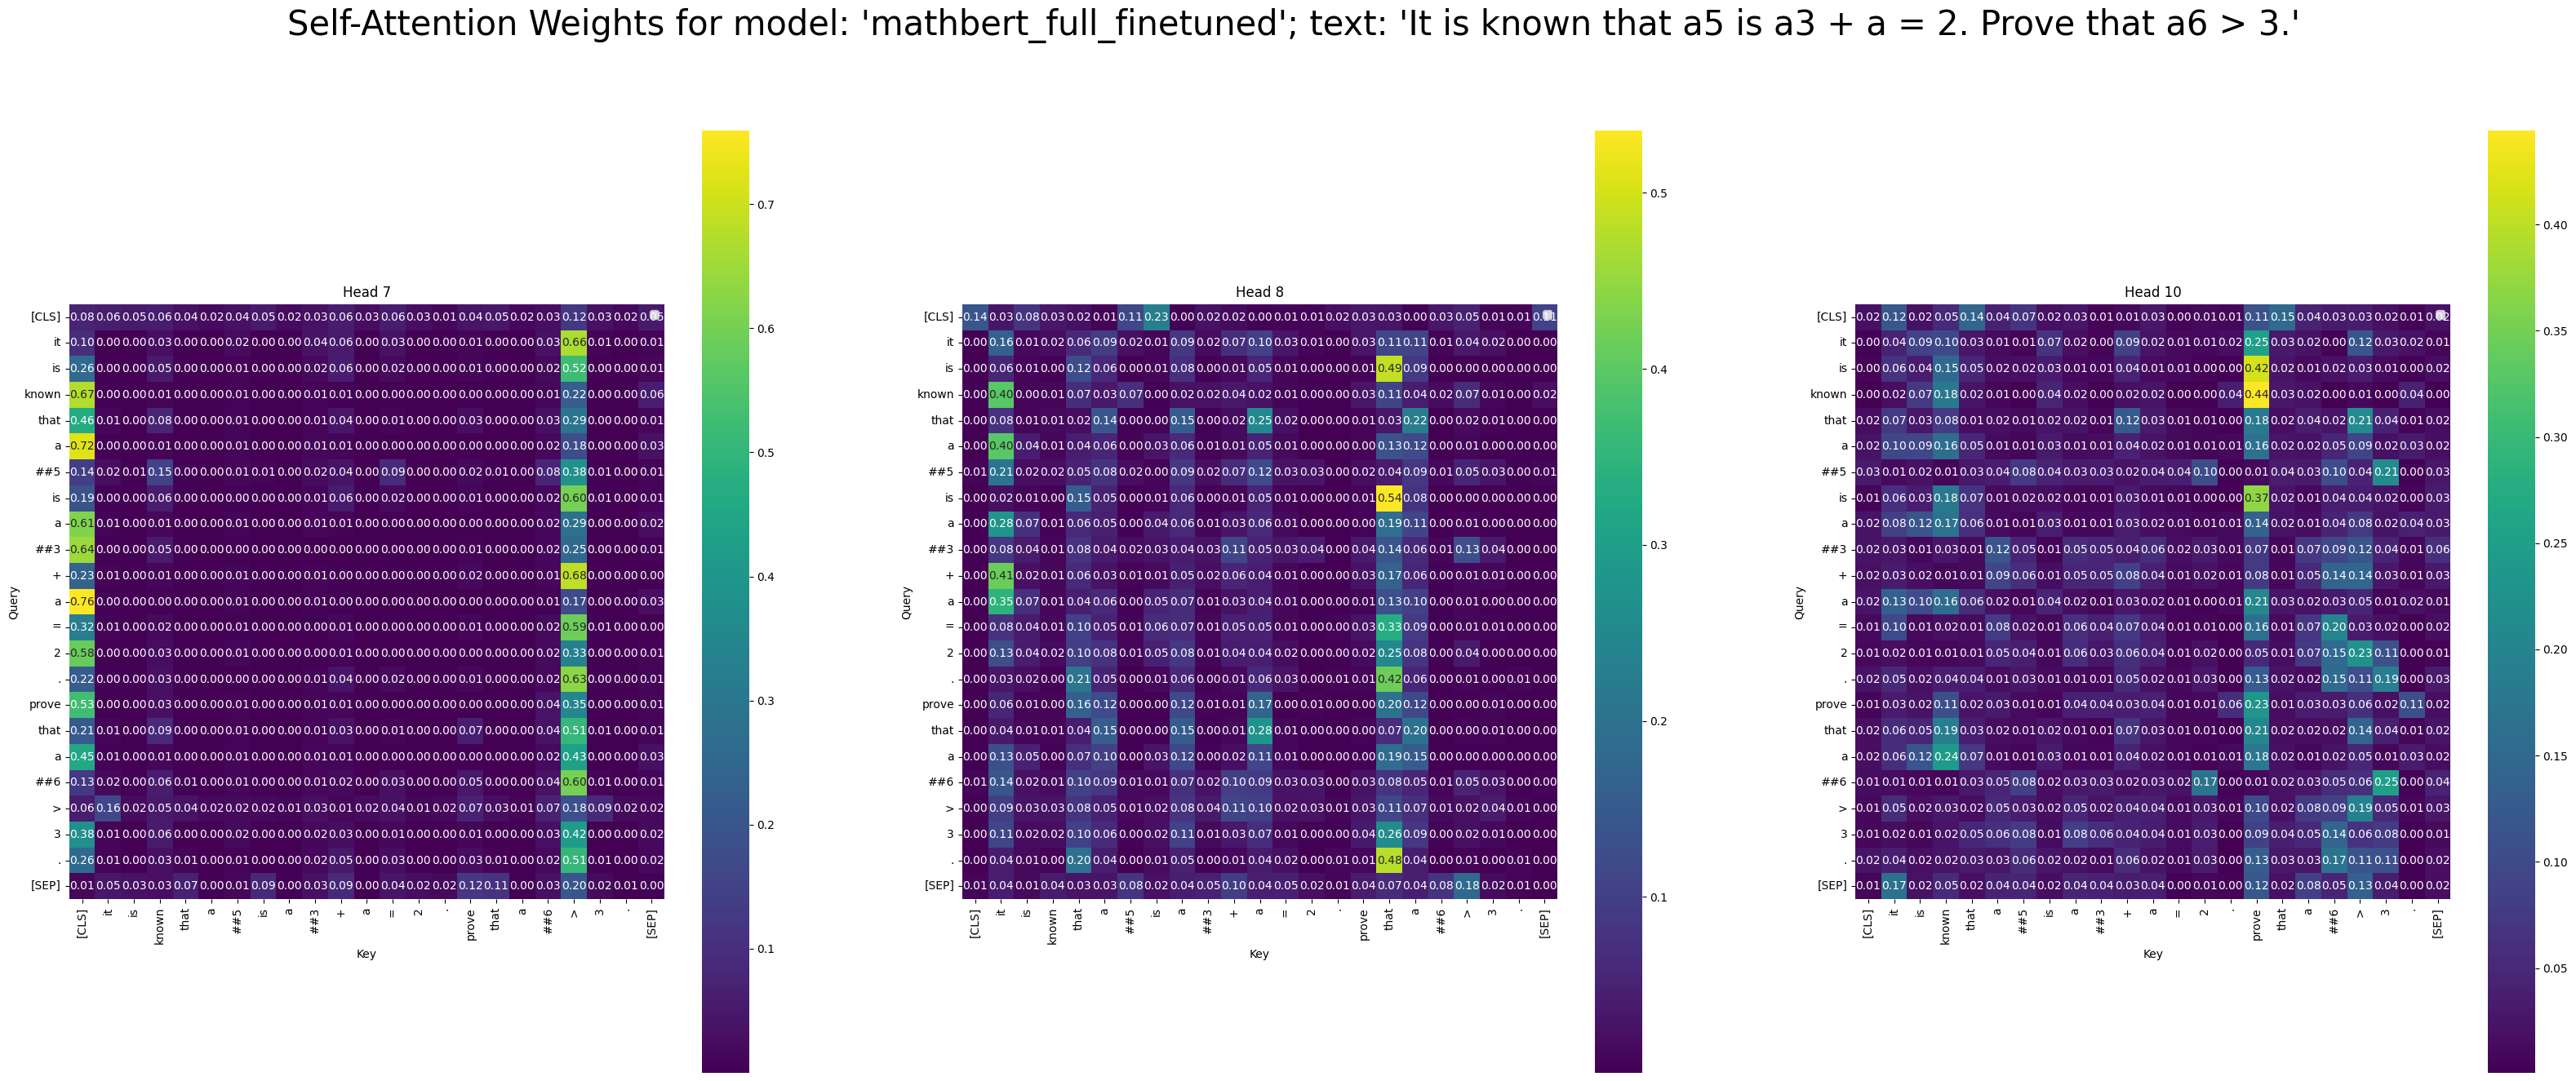

Predicted label: polynoms; Real label: polynoms


In [ ]:
for i in range(len(texts)):
    draw_first_layer_attention_maps(
        text=texts[i],
        label=labels[i],
        attention_head_ids=mathbert_attention_head_ids,
        model=mathbert_full_finetuned,
        model_name='mathbert_full_finetuned'
    )

Аналогично, почти нет изменений